# Suggestion to Reader: Scroll to Bottom _First_

There's one cell that wraps everything together in a concise, functional demo.

In [105]:
%matplotlib notebook

import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitty_dir = 'kitti/drives'
kitty_date = '2011_09_26'
kitty_drive = '0002'

kitti = pykitti.raw(kitty_dir, kitty_date, kitty_drive, frames=range(0, 72, 1))
K = kitti.calib.K_cam0
imgs = kitti.cam0

<IPython.core.display.Javascript object>


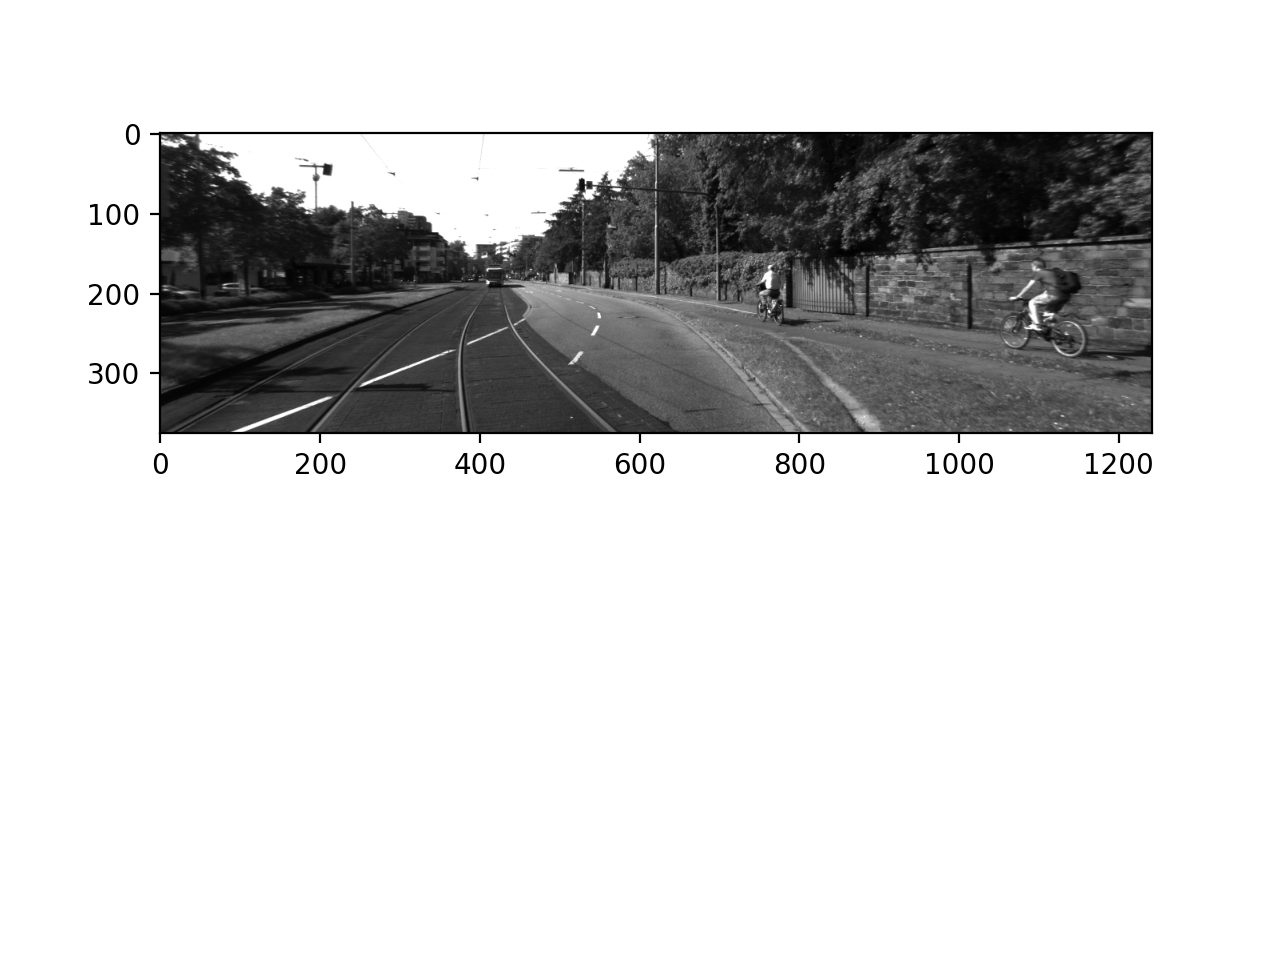

TypeError: 'str' object is not callable

In [79]:
img1 = np.array(next(imgs))
img2 = np.array(next(imgs))
img3 = np.array(next(imgs))

plt.subplot(2, 1, 1)
plt.imshow(img1, cmap='gray')
plt.title('Image')
plt.show()
plt.subplot(2, 1, 2)
plt.imshow(img2, cmap='gray')
plt.title('Image')
plt.show()

## Detect Features

<IPython.core.display.Javascript object>


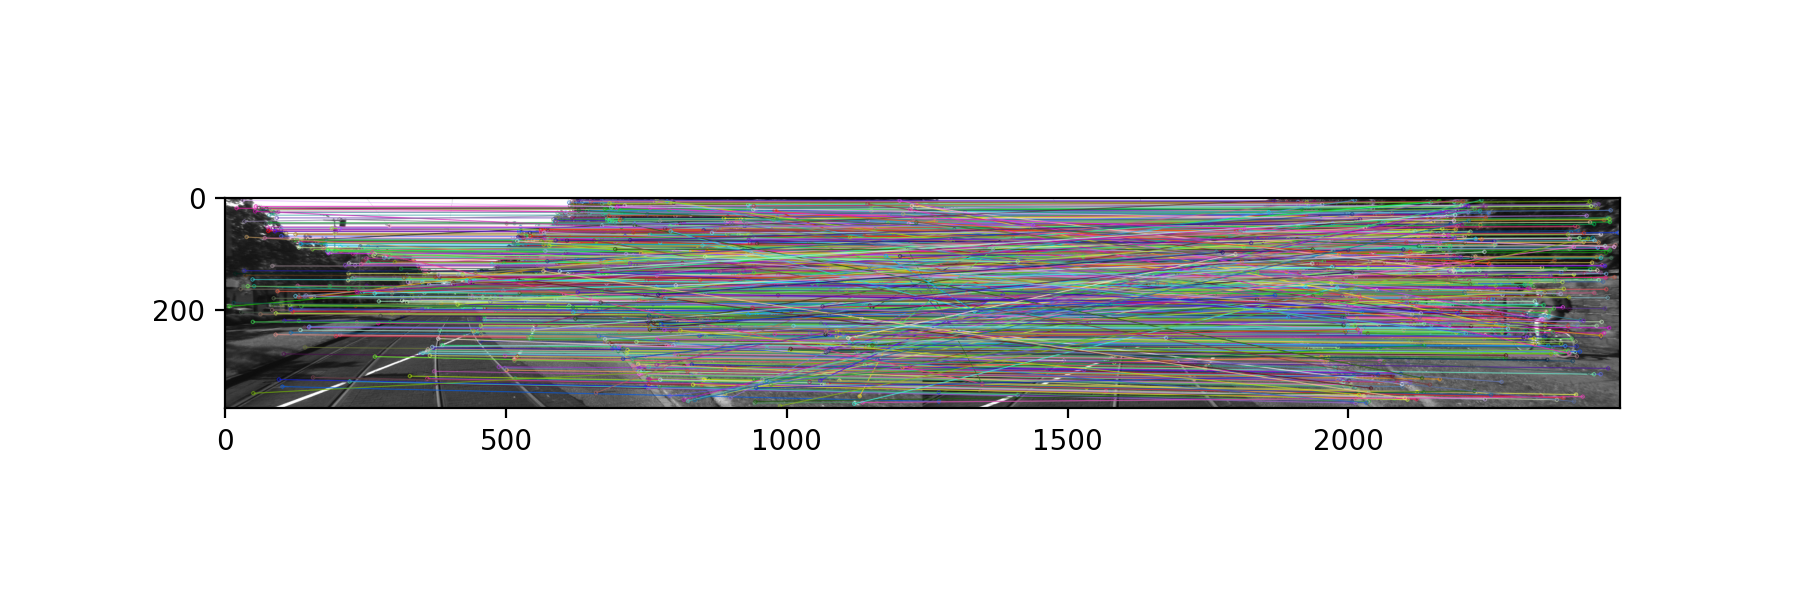

Keeping 663/1708 points that match the fundamental matrix
E: [[ 1.74365115e-01 -1.47393907e+02  5.06786273e-01]
 [ 1.47573885e+02  6.23198845e-02  1.06547208e-01]
 [-1.30352508e+00 -7.77499347e-01  1.72959282e-03]]


In [80]:
def detect_matches_and_E(img1, img2, draw=True):
	# Find Matches
	# From: https://stackoverflow.com/a/33670318
	sift = cv2.SIFT_create()
	orb = cv2.ORB_create()
	kp1, des1 = sift.detectAndCompute(img1, None)
	kp2, des2 = sift.detectAndCompute(img2, None)
	bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
	matches = bf.match(des1, des2)
	matches = sorted(matches, key=lambda x: x.distance)

	if draw:
		match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
		plt.figure(figsize=(9, 3))
		plt.imshow(match_img)
		plt.show()

	# Find Points
	# From book
	imgpts1 = []
	imgpts2 = []
	for match in matches:
		imgpts1.append(kp1[match.queryIdx].pt)
		imgpts2.append(kp2[match.trainIdx].pt)
	
	points1 = np.array(imgpts1)
	points2 = np.array(imgpts2)
	
	F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 100000)
	E = K.T @ F @ K
	
	if draw:
		print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")

	status_mask = status_mask[:, 0] == 1
	points1 = points1[status_mask]
	points2 = points2[status_mask]

	return points1, points2, matches, E

points1, points2, matches, E = detect_matches_and_E(img1, img2)

print("E:", E)

<IPython.core.display.Javascript object>


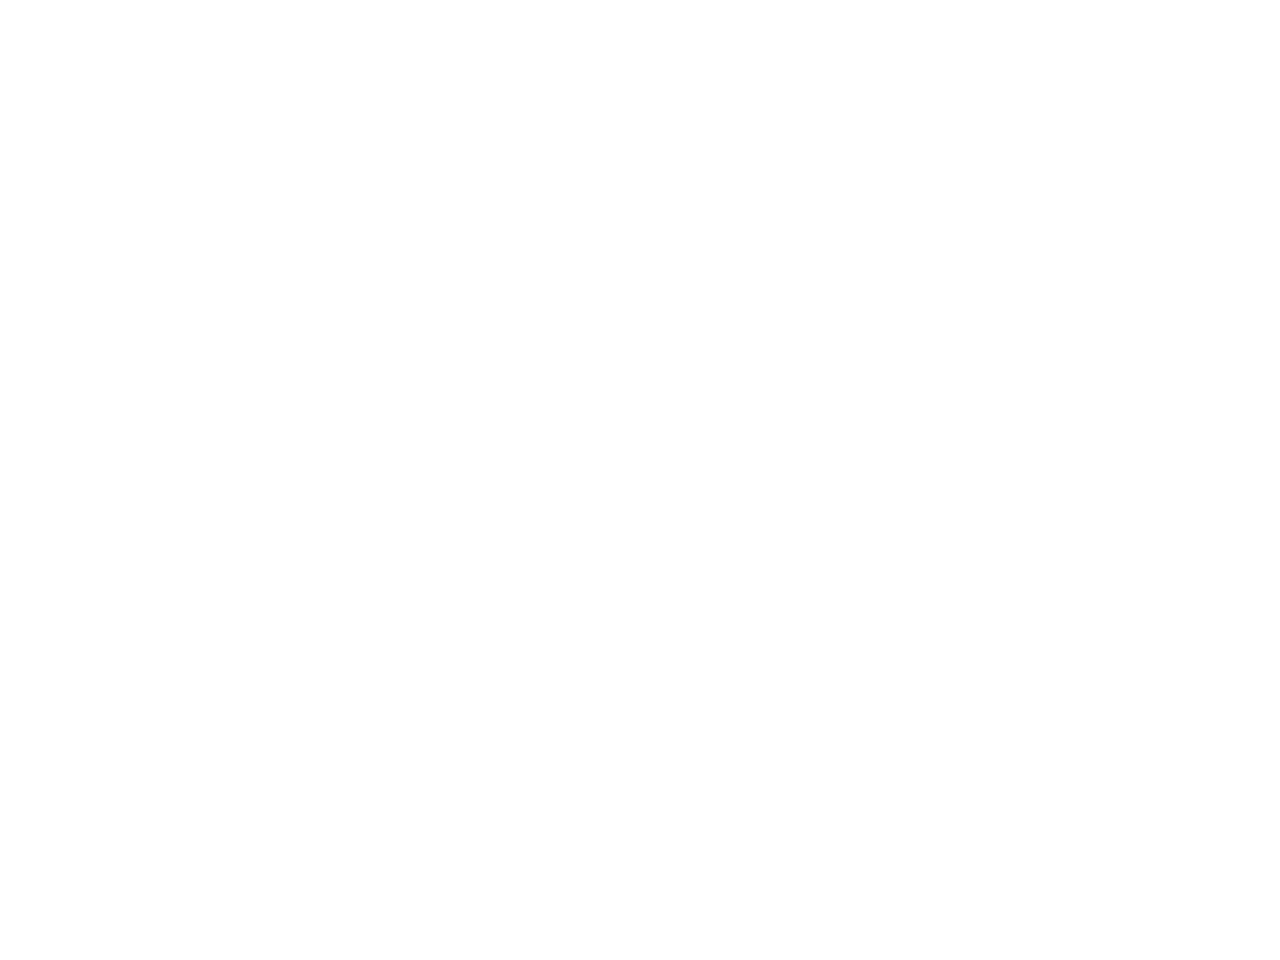

TypeError: 'str' object is not callable

In [82]:
plt.figure()
plt.title('Points from Image 1')
plt.scatter(points1[:, 0], -1 * points1[:, 1])
plt.gca().set_aspect('equal')
plt.show()

In [83]:
# From book
def P_from_E(E):
	# ???: It seems like all the data here is in w, which we
	w, u, vt = cv2.SVDecomp(E)

	W = np.array([
		[0, -1 , 0],
		[1, 0, 0],
		[0, 0, 1]
	])

	R = u @ W @ vt
	t = u[:, 2]

	assert np.abs(np.linalg.det(R)) - 1.0 <= 1e-07, "det(R) != ±1.0, this isn't a rotation matrix!"

	P = np.hstack((R, t[:, np.newaxis]))
	return P

P1 = P_from_E(E)
# P0 is assumed to be fixed
P0 = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])

print("P0:", P0)
print("P1:", P1)

P0: [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
P1: [[-9.99981694e-01 -8.45029610e-04 -5.99151812e-03 -5.27095968e-03]
 [ 7.71424312e-04 -9.99924342e-01  1.22766026e-02  8.83879369e-03]
 [-6.00143891e-03  1.22717559e-02  9.99906689e-01  9.99947045e-01]]


## Triangulation

In [84]:
# From book
def triangulate(
	# NOTE: u and u1 need to be normalized (multiplied by K, or P0 and P1 do)
	u0: np.array, # point in image 1: (x, y, 1)
	P0: np.array, # camera 1 matrix
	u1: np.array, # point in image 2: (x, y, 1)
	P1: np.array, # camera 2 matrix
):
	# XXX: I don't quite understand this
	A = np.array([
		[u0[0]*P0[2,0]-P0[0,0], u0[0]*P0[2,1]-P0[0,1], u0[0]*P0[2,2]-P0[0,2]],
		[u0[1]*P0[2,0]-P0[1,0], u0[1]*P0[2,1]-P0[1,1], u0[1]*P0[2,2]-P0[1,2]],
		[u1[0]*P1[2,0]-P1[0,0], u1[0]*P1[2,1]-P1[0,1], u1[0]*P1[2,2]-P1[0,2]],
		[u1[1]*P1[2,0]-P1[1,0], u1[1]*P1[2,1]-P1[1,1], u1[1]*P1[2,2]-P1[1,2]]
	])

	B = np.array([
		-(u0[0]*P0[2, 3]-P0[0, 3]),
		-(u0[1]*P0[2, 3]-P0[1, 3]),
		-(u1[0]*P1[2, 3]-P1[0, 3]),
		-(u1[1]*P1[2, 3]-P1[1, 3])
	])

	_, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
	return np.array([*X[:, 0], 1.0])


In [85]:
from collections import namedtuple

class CloudPoint(namedtuple('CloudPoint', ['point_3d', 'point_2d_2'])):
	def __eq__(self, other):
		return np.array_equal(self.point_3d, other.point_3d) and np.array_equal(self.point_2d_2, other.point_2d_2)

# From book
def triangulate_points(
	pt_set1: np.array,
	pt_set2: np.array,
	K: np.array,
	P0: np.array,
	P1: np.array,
):
	Kinv = np.linalg.inv(K)
	point_cloud = []
	reproj_error = []
	
	for i in range(len(pt_set1)):
		# Convert to normalized, homogeneous coordinates
		u0 = Kinv @ np.array([*pt_set1[i], 1.0])
		u1 = Kinv @ np.array([*pt_set2[i], 1.0])

		# Triangulate
		X = triangulate(u0, P0, u1, P1)
		cloudpoint = CloudPoint(X[0:3], pt_set2[i])

		if cloudpoint in point_cloud:
			continue

		# Calculate reprojection error
		reproj = K @ P1 @ X
		reproj_normalized = reproj[0:1] / reproj[2]
		reproj_error.append(np.linalg.norm(reproj_normalized))
		point_cloud.append(cloudpoint)
	
	# Return mean reprojection error
	return np.mean(reproj_error), point_cloud


err, point_cloud = triangulate_points(points1, points2, K, P0, P1)
print("Mean reprojection error:", err)


Mean reprojection error: 702.5495751121023


<IPython.core.display.Javascript object>


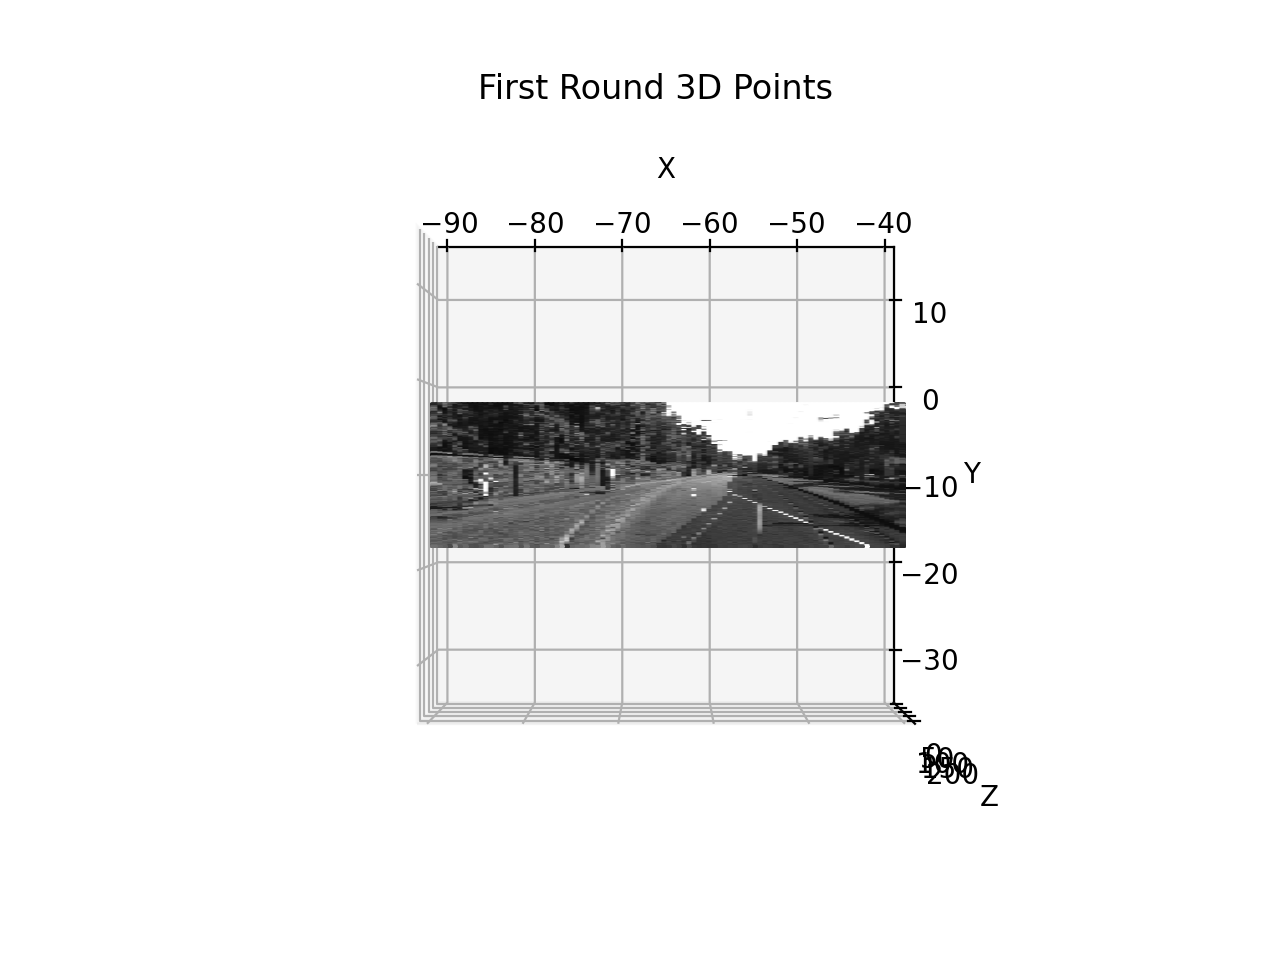

img_scaled.shape: (621, 187)
X width/min/center/max: -25.0/-40.0/-65.0/-90.0, Y with/min/center/max: -7.528180354267311/-2.4718196457326886/-10.0/-17.528180354267313
shapes: X1: (621, 187) Y1: (621, 187) Z1: (621, 187) img_scaled_rot: (621, 187) cmap: (621, 187, 3)


In [86]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for cp in point_cloud:
	ax.scatter(*cp.point_3d)

# Scale image for performanc
img_scaled = cv2.resize(img1, dsize=(img1.shape[0] // 2, img1.shape[1] // 2), interpolation=cv2.INTER_CUBIC)
# img_scaled = np.rot90(img_scaled)

print("img_scaled.shape:", img_scaled.shape)
    
# FIXME: These are all guesses
X_CENTER = -65.
Y_CENTER = -10.
WIDTH = -25.

biggest_axis = max(img_scaled.shape)

X_WIDTH = WIDTH * (img_scaled.shape[0] / biggest_axis)
Y_WIDTH = WIDTH * (img_scaled.shape[1] / biggest_axis)

X_MIN = X_CENTER - X_WIDTH
X_MAX = X_CENTER + X_WIDTH
Y_MIN = Y_CENTER - Y_WIDTH
Y_MAX = Y_CENTER + Y_WIDTH

print(f"X width/min/center/max: {X_WIDTH}/{X_MIN}/{X_CENTER}/{X_MAX}, Y with/min/center/max: {Y_WIDTH}/{Y_MIN}/{Y_CENTER}/{Y_MAX}")
    
ax.set_title('First Round 3D Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(X_CENTER - WIDTH, X_CENTER + WIDTH)
ax.set_ylim(Y_CENTER - WIDTH, Y_CENTER + WIDTH)


# 10 is equal length of x and y axises of your surface
stepX, stepY = (X_MAX - X_MIN) / img_scaled.shape[1], (Y_MAX - Y_MIN) / img_scaled.shape[0]

X1 = np.arange(X_MIN, X_MAX, stepX)
Y1 = np.arange(Y_MIN, Y_MAX, stepY)
X1, Y1 = np.meshgrid(X1, Y1)
Z1 = np.zeros_like(X1)
Z1.fill(215)

img_scaled_rot = img_scaled #np.rot90(img_scaled_rot)

cmap = np.zeros((*img_scaled_rot.shape, 3))
cmap[:, :, 0] = img_scaled_rot / 255.
cmap[:, :, 1] = img_scaled_rot / 255.
cmap[:, :, 2] = img_scaled_rot / 255.

print("shapes:", "X1:", X1.shape, "Y1:", Y1.shape, "Z1:", Z1.shape, "img_scaled_rot:", img_scaled_rot.shape, "cmap:", cmap.shape)

# stride args allows to determine image quality 
# stride = 1 work slow
ax.plot_surface(X1, Y1, Z1, rstride=2, cstride=2, shade=False, facecolors=cmap)

ax.view_init(90, 90)

plt.show()

From the above image, I think it's working although the visualization clearly isn't right.

In [87]:
def P_from_PnP(point_cloud, points2, K):
	# Not really from book, because the book's implementation of this is incomprehensible
	success, rvec, t, inliers = cv2.solvePnPRansac(np.array([p.point_3d for p in point_cloud]), points2, K, None)
	assert success, "PnP failed!"

	R, _ = cv2.Rodrigues(rvec)

	P = np.hstack((R, t))
	return P, R, t

In [88]:
P1_new, R, t = P_from_PnP(point_cloud, points2, K)
print("Difference between E-based P1 and PnP-based P1 (should be ~0, since it's the same data):", np.sum(P1 - P1_new))

error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/solvepnp.cpp:241: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'


## Try a 3rd Frame

In [ ]:
# I made this part up, although it's an amalgamation of code from above which came from other places
points2, points3, matches, _ = detect_matches_and_E(img2, img3)

points3_valid = []

for point2, point3 in zip(points2, points3):
	for cp in point_cloud:
		if np.array_equal(point2, cp.point_2d_2):
			points3_valid.append((cp, point3))
			break

print(f"Keeping {len(points3_valid)}/{len(points3)} frame3 points, others weren't present in frames1/2")

P2, R, t = P_from_PnP((cp for cp, _ in points3_valid), np.array([point3 for cp, point3 in points3_valid]), K)

P0, P1, P2

In [ ]:
success, rvec, t, inliers = cv2.solvePnPRansac(np.array([cp.point_3d for cp, point3 in points3_valid]), np.array([point3 for cp, point3 in points3_valid]), K, None)
assert success, "PnP failed!"

R, _ = cv2.Rodrigues(rvec)

P2 = np.hstack((R, t))
P0, P1, P2

### Re-triangulate

In [ ]:
err, point_cloud = triangulate_points(points2, points3, K, P1, P2)
print("Mean reprojection error:", err)

In [ ]:
# Helper
def normalize(v, *args, **kwargs):
    return v / np.linalg.norm(v, *args, **kwargs)

## Continuous

<IPython.core.display.Javascript object>


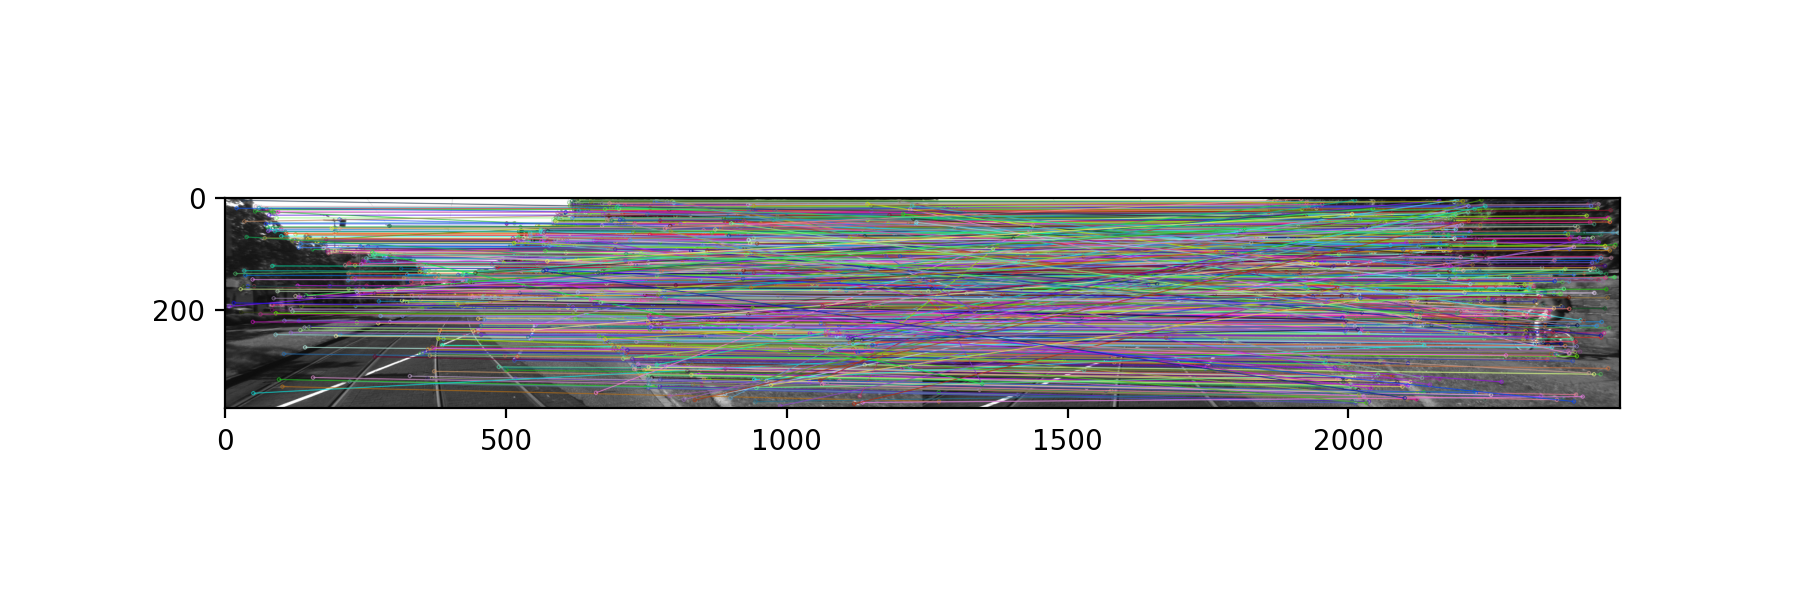

Keeping 663/1708 points that match the fundamental matrix
Keeping 282/636 new points, others weren't present in previous frame.
[[-9.98960743e-01  2.51613640e-03  4.55093788e-02  1.90002431e-02]
 [-5.02731655e-04 -9.99022621e-01  4.41989771e-02  2.28394861e-02]
 [ 4.55761096e-02  4.41301640e-02  9.97985645e-01  9.80255520e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Mean reprojection error: 703.4021386657045
Keeping 291/628 new points, others weren't present in previous frame.
[[-0.9951429   0.00913055  0.09801649  0.04422685]
 [-0.00518815 -0.99917006  0.0404015   0.01848591]
 [ 0.09830403  0.03969675  0.99436436  0.95850989]
 [ 0.          0.          0.          1.        ]] [[-9.98960743e-01  2.51613640e-03  4.55093788e-02  1.90002431e-02]
 [-5.02731655e-04 -9.99022621e-01  4.41989771e-02  2.28394861e-02]
 [ 4.55761096e-02  4.41301640e-02  9.97985645e-01  9.80255520e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00

Mean reprojection error: 788.246198136665
Keeping 440/956 new points, others weren't present in previous frame.
[[-0.67352117  0.12238942  0.72896506  0.37912166]
 [ 0.03331323 -0.9801687   0.19534469  0.10347166]
 [ 0.73841686  0.15585296  0.65608718  0.49958977]
 [ 0.          0.          0.          1.        ]] [[ 0.85099769 -0.34204421  0.39850808  5.15882412]
 [ 0.34540533  0.93613703  0.06589856  1.23202685]
 [-0.39559839  0.08156729  0.91479434 11.70705626]
 [ 0.          0.          0.          1.        ]]
Mean reprojection error: 807.1948615853
Keeping 308/808 new points, others weren't present in previous frame.
[[-0.64863351  0.12953146  0.74999745  0.3906339 ]
 [ 0.03213354 -0.97987202  0.19702352  0.10411305]
 [ 0.76042225  0.15189613  0.63141552  0.47379725]
 [ 0.          0.          0.          1.        ]] [[-0.81926841  0.40440699  0.40651478  5.58936645]
 [-0.38748405 -0.91303308  0.12738409  1.35464582]
 [ 0.42267646 -0.05315623  0.90472041 12.18181709]
 [ 0.     

Mean reprojection error: 811.9536543585473
Keeping 200/586 new points, others weren't present in previous frame.
[[-0.39200256  0.21295985  0.89497603  0.46335975]
 [ 0.05170921 -0.9661995   0.25255631  0.13204009]
 [ 0.91850974  0.14528122  0.36774069  0.20303202]
 [ 0.          0.          0.          1.        ]] [[-0.09057848 -0.81560772  0.57147142 11.74746197]
 [ 0.99327793 -0.03245861  0.11110987  2.56156819]
 [-0.0720729   0.57769411  0.8130652  17.50993399]
 [ 0.          0.          0.          1.        ]]
Mean reprojection error: 745.1710854427016
Keeping 252/662 new points, others weren't present in previous frame.
[[-0.38004237  0.21529804  0.89956353  0.46520758]
 [ 0.05260631 -0.96592846  0.25340637  0.13237597]
 [ 0.92347191  0.14362787  0.35576771  0.19013379]
 [ 0.          0.          0.          1.        ]] [[ 0.1825318   0.82983032  0.52731754 12.07480688]
 [-0.98259084  0.13508735  0.12754079  2.68675051]
 [ 0.03460328 -0.54141763  0.8400414  17.80445335]
 [ 0. 

Keeping 249/605 new points, others weren't present in previous frame.
[[-0.29014052  0.22967848  0.9290136   0.47396921]
 [ 0.06057682 -0.96441763  0.25735012  0.13306408]
 [ 0.95506488  0.13094438  0.26590345  0.05173889]
 [ 0.          0.          0.          1.        ]] [[-7.63359407e-01  2.52599748e-01  5.94538294e-01  1.64660996e+01]
 [-2.02273376e-01 -9.67559414e-01  1.51374572e-01  3.40233986e+00]
 [ 6.13488303e-01 -4.70606402e-03  7.89689784e-01  2.17312668e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 714.2594088240819
Keeping 218/527 new points, others weren't present in previous frame.
[[-0.28598175  0.22824472  0.93065503  0.47434214]
 [ 0.06265484 -0.96468555  0.25584401  0.13213484]
 [ 0.95618451  0.13147676  0.26158183  0.04332287]
 [ 0.          0.          0.          1.        ]] [[ 0.74496264 -0.29988899  0.59590038 16.66657311]
 [ 0.30671542  0.94722194  0.09325369  3.44179553]
 [-0.59241567  0.11330132  0.7976255

Keeping 185/480 new points, others weren't present in previous frame.
[[-0.27636214  0.23350846  0.93225413  0.47431122]
 [ 0.05920185 -0.96405485  0.25902391  0.13339706]
 [ 0.95922839  0.12677557  0.25260413 -0.05742517]
 [ 0.          0.          0.          1.        ]] [[ 0.37766342  0.72390167  0.5773532  19.54191557]
 [-0.91640001  0.38150337  0.1211041   4.00996425]
 [-0.13259473 -0.57482306  0.80746336 25.35341977]
 [ 0.          0.          0.          1.        ]]
Mean reprojection error: 683.4203499114878
Keeping 197/485 new points, others weren't present in previous frame.
[[-0.27688778  0.23105371  0.93270968  0.47467827]
 [ 0.06302517 -0.96420327  0.2575653   0.13199138]
 [ 0.95883314  0.13010086  0.2524139  -0.06425561]
 [ 0.          0.          0.          1.        ]] [[-0.44197101 -0.64685593  0.62148132 19.64585643]
 [ 0.87147304 -0.47382677  0.12658171  3.99163108]
 [ 0.21259436  0.59754966  0.7731352  25.60047919]
 [ 0.          0.          0.          1.        

In [115]:
# I made this part up, although it's an amalgamation of code from above which came from other places
# This cell is self-contained from a state perspective, but not a logic one
from itertools import islice

### Setup ###
K = kitti.calib.K_cam0
imgs = (np.array(img) for img in kitti.cam0)

img0 = next(imgs)
img1 = next(imgs)

points0, points1, matches, E = detect_matches_and_E(img0, img1)
# P0 is assumed to be fixed to start
P0 = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])
P1 = P_from_E(E)
Ps = [P0, P1]
Es = [E]
cur_pose = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
poses = [cur_pose]
err, point_cloud = triangulate_points(points0, points1, K, P0, P1)




### Graph ###
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# for cp in point_cloud:
# 	ax.scatter(*cp.point_3d)

# ax.set_title('First Round 3D Points')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()

### Run ###

for img in islice(imgs, 72):
	img0, img1 = img1, img
	points0, points1, matches, E = detect_matches_and_E(img0, img1, draw=False)
	Es.append(E)
	points1_valid = []

	for point0, point1 in zip(points0, points1):
		for cp in point_cloud:
			if np.array_equal(point0, cp.point_2d_2):
				points1_valid.append((cp, point1))
				break
	
	print(f"Keeping {len(points1_valid)}/{len(points1)} new points, others weren't present in previous frame.")

	P0 = P1
	P1, R, t = P_from_PnP((cp for cp, _ in points1_valid), np.array([point1 for cp, point1 in points1_valid]), K)
	Ps.append(P1)
	P1_fixed = np.vstack((P1, [0,0,0,1]))
	print(P1_fixed, cur_pose)
	cur_pose = (P1_fixed @ cur_pose)
	poses.append(cur_pose)

	err, point_cloud = triangulate_points(points0, points1, K, P0, P1)
	print("Mean reprojection error:", err)


<IPython.core.display.Javascript object>


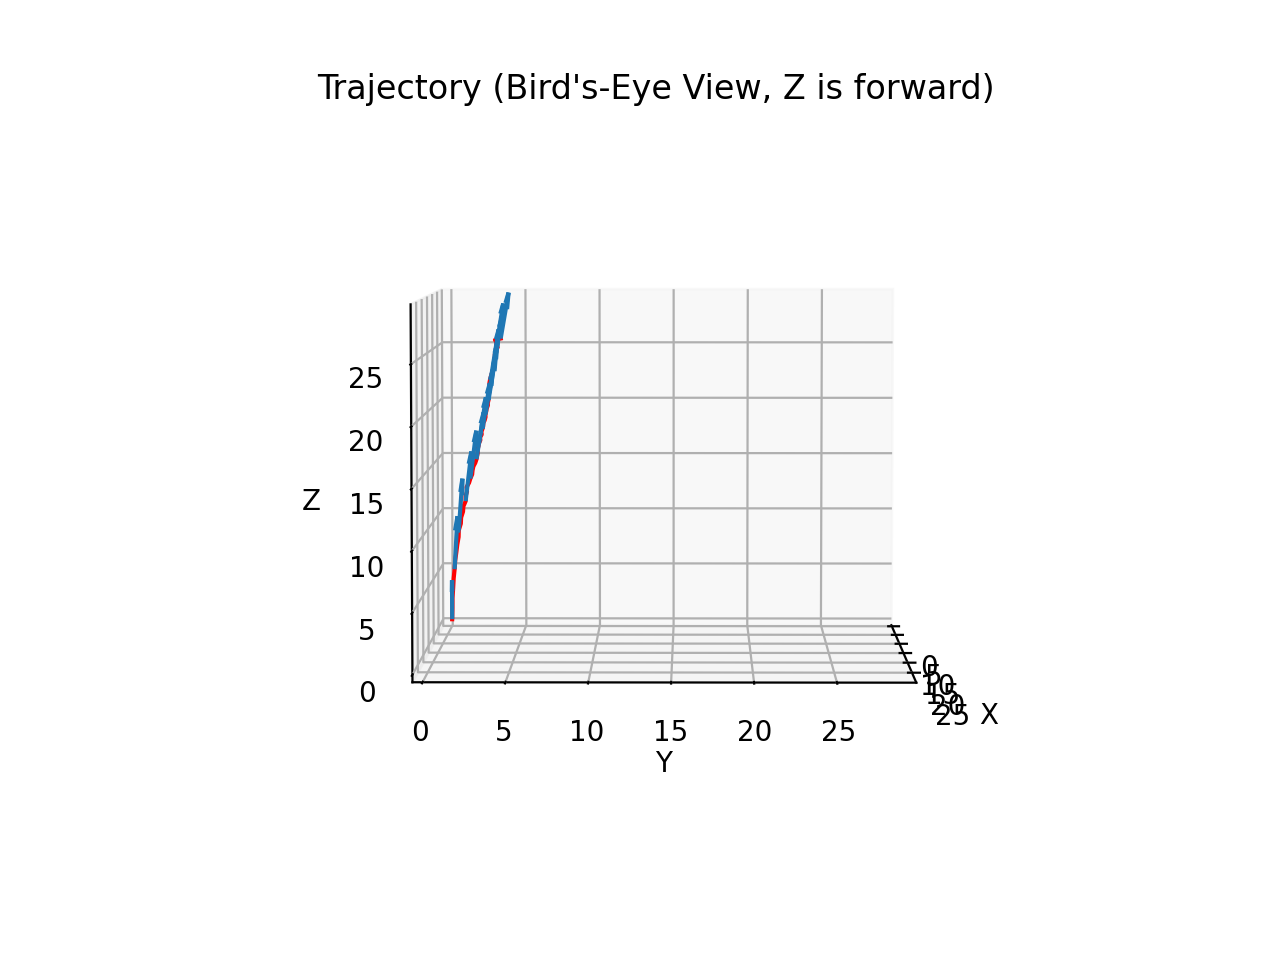

In [122]:
ARROW_SIZE = 5 # nonsense because we have no scale factor
ARROW_PROPORTION = 5 # only show every 5 arrows

XYZ = np.array([P @ np.array([[0,0,0,1]]).transpose() for P in poses]).squeeze(axis=2)

UVW = np.array([normalize(P @ np.array([[0,0,1,1]]).transpose()) * ARROW_SIZE for P in poses]).squeeze(axis=2)

MIN = 0
MAX = np.max(XYZ) * 1.10

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.quiver(
    XYZ[::ARROW_PROPORTION, 0], XYZ[::ARROW_PROPORTION, 1], XYZ[::ARROW_PROPORTION, 2],
    UVW[::ARROW_PROPORTION, 0], UVW[::ARROW_PROPORTION, 1], UVW[::ARROW_PROPORTION, 2])
ax.plot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], 'r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(MIN, MAX)
ax.set_ylim(MIN, MAX)
ax.set_zlim(MIN, MAX)

ax.view_init(0, 90)
ax.set_title("Trajectory (Bird's-Eye View, Z is forward)")
plt.show()